In [2]:
import torch
import torchcde

In [6]:
def _solve_cde(x):
    # x should be a tensor of shape (..., length, channels), and may have missing data represented by NaNs.

    # Create dataset
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(x)
    print('The shape of coeffs:', coeffs.shape)

    # Create model
    input_channels = x.size(-1)
    hidden_channels = 4  # hyperparameter, we can pick whatever we want for this
    output_channels = 10  # e.g. to perform 10-way multiclass classification

    class F(torch.nn.Module):
        def __init__(self):
            super(F, self).__init__()
            # For illustrative purposes only. You should usually use an MLP or something. A single linear layer won't be
            # that great.
            self.linear = torch.nn.Linear(hidden_channels,
                                          hidden_channels * input_channels)

        def forward(self, t, z):
            batch_dims = z.shape[:-1]
            return self.linear(z).tanh().view(*batch_dims, hidden_channels, input_channels)

    class Model(torch.nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.initial = torch.nn.Linear(input_channels, hidden_channels)
            self.func = F()
            self.readout = torch.nn.Linear(hidden_channels, output_channels)

        def forward(self, coeffs):
            X = torchcde.CubicSpline(coeffs)
            X0 = X.evaluate(X.interval[idx])
            z0 = self.initial(X0)
            zt = torchcde.cdeint(X=X, func=self.func, z0=z0, t=X.interval)
            zT = zt[..., -1, :]  # get the terminal value of the CDE
            return self.readout(zT)

    model = Model()

    # Run model
    return model(coeffs)

In [7]:
def irregular_data():
    ######################
    # Begin by generating some example data.
    ######################

    # Batch of three elements, each of two channels. Each element and channel are sampled at different times, and at a
    # different number of times.
    t1a, t1b = torch.rand(7).sort().values, torch.rand(5).sort().values
    t2a, t2b = torch.rand(9).sort().values, torch.rand(7).sort().values
    t3a, t3b = torch.rand(8).sort().values, torch.rand(3).sort().values
    x1a, x1b = torch.rand_like(t1a), torch.rand_like(t1b)
    x2a, x2b = torch.rand_like(t2a), torch.rand_like(t2b)
    x3a, x3b = torch.rand_like(t3a), torch.rand_like(t3b)
    # Overall this has irregular sampling, missing data, and variable lengths.

    ######################
    # We begin by putting handling each batch element individually. Here we handle the problems of irregular sampling
    # and missing data.
    ######################

    def process_batch_element(ta, tb, xa, xb):
        # First get all the times that the batch element was sampled at, across all channels.
        t, sort_indices = torch.cat([ta, tb]).sort()
        # Now add NaNs to each channel where the other channel was sampled.
        xa_ = torch.cat([xa, torch.full_like(xb, float('nan'))])[sort_indices]
        xb_ = torch.cat([torch.full_like(xa, float('nan')), xb])[sort_indices]
        # Add observational masks, 从头到idx, 非Nan的数量
        maska = (~torch.isnan(xa_)).cumsum(dim=0)
        maskb = (~torch.isnan(xb_)).cumsum(dim=0)
        # Stack (time, observation, mask) together into a tensor of shape (length, channels).
        return torch.stack([t, xa_, xb_, maska, maskb], dim=1)

    x1 = process_batch_element(t1a, t1b, x1a, x1b)
    x2 = process_batch_element(t2a, t2b, x2a, x2b)
    x3 = process_batch_element(t3a, t3b, x3a, x3b)

    # Note that observational masks can of course be omitted if the data is regularly sampled and has no missing data.
    # Similarly the observational mask may be only a single channel (rather than on a per-channel basis) if there is
    # irregular sampling but no missing data.

    ######################
    # Now pad out every shorter sequence by filling the last value forward. The choice of fill-forward here is crucial.
    ######################

    max_length = max(x1.size(0), x2.size(0), x3.size(0))

    def fill_forward(x):
        # fill forward, 将最后一行重复，直至长度为max_length
        return torch.cat([x, x[-1].unsqueeze(0).expand(max_length - x.size(0), x.size(1))])

    x1 = fill_forward(x1)
    x2 = fill_forward(x2)
    x3 = fill_forward(x3)

    ######################
    # Batch everything together
    ######################
    x = torch.stack([x1, x2, x3])

    ######################
    # Solve a Neural CDE: this bit is standard, and just included for completeness.
    ######################

    return x


In [4]:
x = torch.randint(0, 10, (3, 4))
# print(x, x.view(x.size(0), 2, 2), x.reshape(x.shape[0], 2, 2), sep='\n')

tensor([[0, 5, 7, 7],
        [0, 8, 5, 6],
        [0, 9, 3, 9]])
tensor([[[0, 5],
         [7, 7]],

        [[0, 8],
         [5, 6]],

        [[0, 9],
         [3, 9]]])
tensor([[[0, 5],
         [7, 7]],

        [[0, 8],
         [5, 6]],

        [[0, 9],
         [3, 9]]])


In [5]:
######################
# So you want to train a Neural CDE model?
# Let's get started!
######################

import math
import torch
import torchcde


######################
# A CDE model looks like
#
# z_t = z_0 + \int_0^t f_\theta(z_s) dX_s
#
# Where X is your data and f_\theta is a neural network. So the first thing we need to do is define such an f_\theta.
# That's what this CDEFunc class does.
# Here we've built a small single-hidden-layer neural network, whose hidden layer is of width 128.
######################
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = torch.nn.Linear(hidden_channels, 128)
        self.linear2 = torch.nn.Linear(128, input_channels * hidden_channels)

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z


######################
# Next, we need to package CDEFunc up into a model that computes the integral.
######################
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation

    def forward(self, coeffs):
        if self.interpolation == 'cubic':
            X = torchcde.CubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        return pred_y


######################
# Now we need some data.
# Here we have a simple example which generates some spirals, some going clockwise, some going anticlockwise.
######################
def get_data(num_timepoints=100):
    t = torch.linspace(0., 4 * math.pi, num_timepoints)

    start = torch.rand(128) * 2 * math.pi
    x_pos = torch.cos(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos[:64] *= -1
    y_pos = torch.sin(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos += 0.01 * torch.randn_like(x_pos)
    y_pos += 0.01 * torch.randn_like(y_pos)
    ######################
    # Easy to forget gotcha: time should be included as a channel; Neural CDEs need to be explicitly told the
    # rate at which time passes. Here, we have a regularly sampled dataset, so appending time is pretty simple.
    ######################
    X = torch.stack([t.unsqueeze(0).repeat(128, 1), x_pos, y_pos], dim=2)
    y = torch.zeros(128)
    y[:64] = 1

    perm = torch.randperm(128)
    X = X[perm]
    y = y[perm]

    ######################
    # X is a tensor of observations, of shape (batch=128, sequence=100, channels=3)
    # y is a tensor of labels, of shape (batch=128,), either 0 or 1 corresponding to anticlockwise or clockwise
    # respectively.
    ######################
    return X, y


def main(num_epochs=30):
    train_X, train_y = get_data()

    ######################
    # input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
    # hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
    # output_channels=1 because we're doing binary classification.
    ######################
    model = NeuralCDE(input_channels=3, hidden_channels=8, output_channels=1)
    optimizer = torch.optim.Adam(model.parameters())

    ######################
    # Now we turn our dataset into a continuous path. We do this here via Hermite cubic spline interpolation.
    # The resulting `train_coeffs` is a tensor describing the path.
    # For most problems, it's probably easiest to save this tensor and treat it as the dataset.
    ######################
    train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_X)

    train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
    for epoch in range(num_epochs):
        for batch in train_dataloader:
            batch_coeffs, batch_y = batch
            pred_y = model(batch_coeffs).squeeze(-1)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_y, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

    test_X, test_y = get_data()
    test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(test_X)
    pred_y = model(test_coeffs).squeeze(-1)
    binary_prediction = (torch.sigmoid(pred_y) > 0.5).to(test_y.dtype)
    prediction_matches = (binary_prediction == test_y).to(test_y.dtype)
    proportion_correct = prediction_matches.sum() / test_y.size(0)
    print('Test Accuracy: {}'.format(proportion_correct))

In [6]:
train_X, train_y = get_data()
print(train_X.shape, train_y.shape)

torch.Size([128, 100, 3]) torch.Size([128])


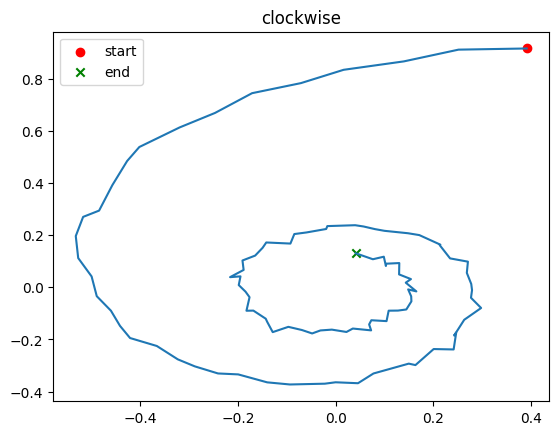

In [20]:
import matplotlib.pyplot as plt
idx = 1
plt.plot(train_X[idx, :, 1], train_X[idx, :, 2])
plt.scatter(train_X[idx, 0, 1], train_X[idx, 0, 2], marker='o', color='red', label='start')
plt.scatter(train_X[idx, -1, 1], train_X[idx, -1, 2], marker='x', color='green', label='end')
plt.title('anticlockwise' if int(train_y[idx].item()) == 1 else 'clockwise')
plt.legend()
plt.show()

In [19]:
print(train_y)

tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        1., 0.])
